Import the libraries

In [1]:
import os
import pandas as pd
import pickle
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
import numpy as np
import matplotlib.pyplot as plt

Specify the datasets

In [2]:
# Define paths and datasets
regression_datasets = [ 'fri_c3_1000_50', 'fri_c2_1000_25', 'fri_c4_500_50', 'fri_c4_1000_50', 'fri_c1_1000_25', 'fri_c1_500_50', 'fri_c3_1000_25', 'auto93', 'pyrim', 'autoPrice', 'boston', 'Concrete_Compressive_Strength', 'Auto_MPG', 'Forest Fires', 'Servo', 'Airfoil_Self_Noise', 'Wine_Quality', 'BodyFat', 'California_Housing', 'Quake']
multi_class_classification_datasets = ['Balance_Scale', 'Iris']

Define a function to find the tree size

In [3]:
def load_and_process_pkl_files(base_path, regression_names):
    results = []

    # List all .pkl files in the directory
    for filename in os.listdir(base_path):
        if filename.endswith('.pkl'):
            # Modify the filename as per thr dataframe name
            modified_name = filename[:-14]
            
            # Load the pickle file
            file_path = os.path.join(base_path, filename)
            with open(file_path, 'rb') as file:
                data = pickle.load(file)

            # Initialize list to store sizes of decision trees
            tree_sizes = []
            
            # Iterate over each fold in the loaded data
            for key in ['fold1', 'fold2', 'fold3', 'fold4', 'fold5']:
                fold_data = data[key]
                train_indep_df = fold_data['Training_Independent']
                train_dep_df = fold_data['Training_Dependent']

                # Determine whether to use a classifier or a regressor
                if modified_name not in regression_names:
                    model = DecisionTreeClassifier(random_state=42)
                else:
                    model = DecisionTreeRegressor(random_state=42)
                
                # Fit the model
                model.fit(train_indep_df, train_dep_df)

                # Calculate the size of the tree (number of nodes)
                tree_size = model.tree_.node_count
                tree_sizes.append(tree_size)
            
            # Calculate the average tree size
            avg_tree_size = sum(tree_sizes) / len(tree_sizes)
            results.append([modified_name, avg_tree_size])

    # Create a DataFrame
    df_results = pd.DataFrame(results, columns=['Dataframe', 'Interpretability_Measure'])
    return df_results


Process each of the datasets

In [4]:
# Paths to the pickle files
Base_path = '../Data/BASIC'
BigFeat_path = '../Data/BIGFEAT'
AutoFeat_path = '../Data/AUTOFEAT'
FT_path = '../Data/FT'
Open_path = '../Data/OPENFE'
SAFE_path = '../Data/SAFE'

#Process the data
Base = load_and_process_pkl_files(Base_path, regression_names=regression_datasets)
BigFeat = load_and_process_pkl_files(BigFeat_path, regression_names=regression_datasets)
AutoFeat = load_and_process_pkl_files(AutoFeat_path, regression_names=regression_datasets)
FT = load_and_process_pkl_files(FT_path, regression_names=regression_datasets)
Open = load_and_process_pkl_files(Open_path, regression_names=regression_datasets)
SAFE = load_and_process_pkl_files(SAFE_path, regression_names=regression_datasets)

Renaming the data for concatenation

In [5]:
# Assuming BigFeat, AutoFeat, FT, Open, and SAFE are your DataFrames
BigFeat.rename(columns={'Interpretability_Measure': 'Interpretability_Measure_BigFeat'}, inplace=True)
AutoFeat.rename(columns={'Interpretability_Measure': 'Interpretability_Measure_AutoFeat'}, inplace=True)
FT.rename(columns={'Interpretability_Measure': 'Interpretability_Measure_FT'}, inplace=True)
Open.rename(columns={'Interpretability_Measure': 'Interpretability_Measure_Open'}, inplace=True)
SAFE.rename(columns={'Interpretability_Measure': 'Interpretability_Measure_SAFE'}, inplace=True)

Combine the dataframes

In [12]:
# Sequentially merge all dataframes on 'Dataframe'
merged_df_cols = Base
merged_df_cols = pd.merge(merged_df_cols, BigFeat, on=['Dataframe'], how='left')
merged_df_cols = pd.merge(merged_df_cols, AutoFeat, on=['Dataframe'], how='left')
merged_df_cols = pd.merge(merged_df_cols, FT, on=['Dataframe'], how='left')
merged_df_cols = pd.merge(merged_df_cols, Open, on=['Dataframe'], how='left')
merged_df_cols = pd.merge(merged_df_cols, SAFE, on=['Dataframe'], how='left')

Finding the interpretability scores

In [14]:
# Columns to take the inverse of
inverse_columns = [
    'Interpretability_Measure',
    'Interpretability_Measure_BigFeat',
    'Interpretability_Measure_AutoFeat',
    'Interpretability_Measure_FT',
    'Interpretability_Measure_Open',
    'Interpretability_Measure_SAFE'
]

# Calculating the inverse
merged_df_cols[inverse_columns] = merged_df_cols[inverse_columns].apply(lambda x: 1 / x)

In [15]:
# Normalize values row-wise
merged_df_cols[inverse_columns] = merged_df_cols[inverse_columns].apply(lambda x: (x - x.min()) / (x.max() - x.min()), axis=1)

Seperate the regression and classification data

In [35]:
regression_datasets = [ 'fri_c3_1000_50', 'fri_c2_1000_25', 'fri_c4_500_50', 'fri_c4_1000_50', 'fri_c1_1000_25', 'fri_c1_500_50', 'fri_c3_1000_25', 'auto93', 'pyrim', 'autoPrice', 'boston', 'Concrete_Compressive_Strength', 'Auto_MPG', 'Forest Fires', 'Servo', 'Airfoil_Self_Noise', 'Wine_Quality', 'BodyFat', 'California_Housing', 'Quake']
regression_df = merged_df_cols[merged_df_cols['Dataframe'].isin(regression_datasets)]
classification_df = merged_df_cols[~merged_df_cols['Dataframe'].isin(regression_datasets)]

Plotting the bar chart - Classification

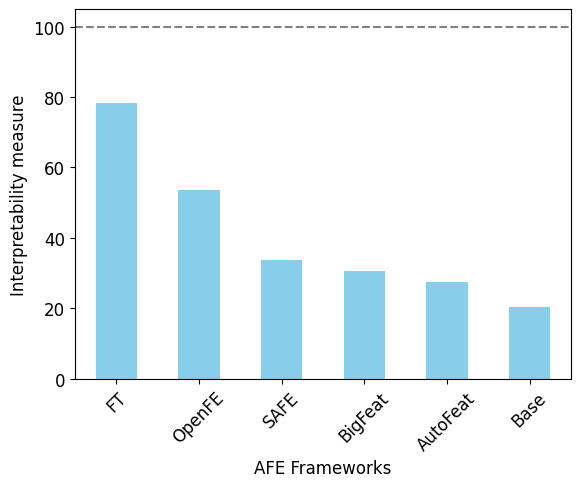

In [36]:
classification_df_cleaned = classification_df.dropna()

# Rename the columns
classification_df_cleaned.columns = ['Dataframe', 'Base', 'BigFeat', 'AutoFeat', 'FT', 'OpenFE', 'SAFE']

# Calculate the mean of the renamed columns
averages = classification_df_cleaned[['Base', 'BigFeat', 'AutoFeat', 'FT', 'OpenFE', 'SAFE']].mean()

# Multiply the averages by 100
averages *= 100

# Sort the averages in descending order
averages = averages.sort_values(ascending=False)

# Plotting
fig, ax = plt.subplots()
# Set all font sizes to 12
plt.rcParams.update({'font.size': 12})
averages.plot(kind='bar', ax=ax, color='skyblue')
ax.axhline(100, color='gray', linestyle='--')  # Add a dotted line at the 100 mark
ax.set_ylabel('Interpretability measure')
ax.set_xlabel('AFE Frameworks')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.savefig('../Diagrams/fig20_A.pdf', format='pdf', bbox_inches='tight')
plt.show()


Plotting the bar plot - Regression

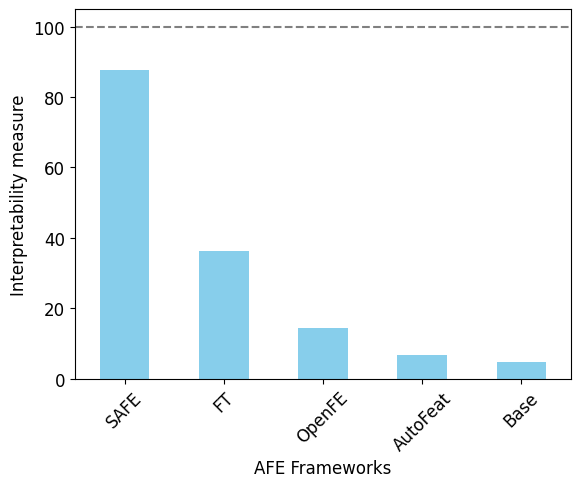

In [37]:
#Remove BigFeat Column
del(regression_df['Interpretability_Measure_BigFeat'])

#Drop the nan values
regression_df_cleaned = regression_df.dropna()

# Rename the columns
regression_df_cleaned.columns = ['Dataframe', 'Base', 'AutoFeat', 'FT', 'OpenFE', 'SAFE']

# Calculate the mean of the renamed columns
averages = regression_df_cleaned[['Base', 'AutoFeat', 'FT', 'OpenFE', 'SAFE']].mean()

# Multiply the averages by 100
averages *= 100

# Sort the averages in descending order
averages = averages.sort_values(ascending=False)

# Plotting
fig, ax = plt.subplots()
# Set all font sizes to 12
plt.rcParams.update({'font.size': 12})
averages.plot(kind='bar', ax=ax, color='skyblue')
ax.axhline(100, color='gray', linestyle='--')  # Add a dotted line at the 100 mark
ax.set_ylabel('Interpretability measure')
ax.set_xlabel('AFE Frameworks')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.savefig('../Diagrams/fig20_B.pdf', format='pdf', bbox_inches='tight')
plt.show()